# Loss Functions Loss

In [7]:
import os, sys, numpy as np
from pathlib import Path
import importlib
import implementation_test_plot as itp

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import config, cv_utils
itp = importlib.reload(itp)  # ensure latest edits are loaded
config = importlib.reload(config)

# Load preprocessed data (cached by run.py)
preproc_path = os.path.join(parent_dir, config.SAVE_PREPROCESSED)
npz = np.load(preproc_path)
X_tr      = npz["X_train"]
X_te      = npz["X_test"]
y_tr_01   = npz["y_train"]
train_ids = npz["train_ids"]
test_ids  = npz["test_ids"]

# Stratified 5-fold indices for reproducible CV
FOLDS = cv_utils.stratified_kfold_indices(y_tr_01, n_splits=5, seed=config.RNG_SEED)

print(f"X_tr {X_tr.shape} X_te {X_te.shape}")
print(f"y_train_01 {y_tr_01.shape}")
print(f"folds {len(FOLDS)}")

X_tr (328135, 402) X_te (109379, 402)
y_train_01 (328135,)
folds 5


## 2D Grid Search: Optimal (γ, λ) for Regularized Logistic Regression

Using itp module: c:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\notebook\implementation_test_plot.py
[Cache] Loaded from data_saving\reglog_heatmap.npz


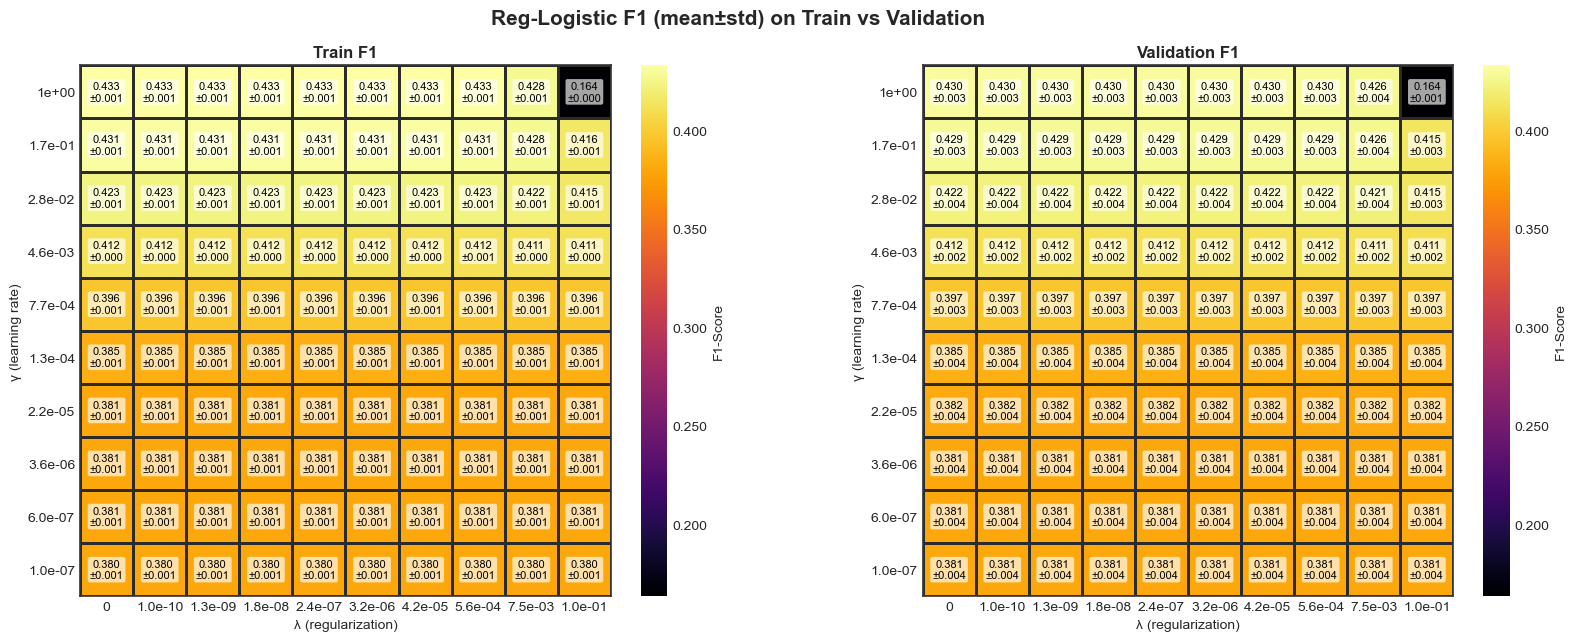

Saved figure to picture\reglog_heatmap_train_val.png


In [8]:
import numpy as np
import os, sys
import importlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter

# Ensure parent directory is on sys.path for clean imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import config
import implementation_test_plot as itp
itp = importlib.reload(itp)  # ensure latest edits are loaded
config = importlib.reload(config)
print("Using itp module:", getattr(itp, "__file__", "<unknown>"))

# Parameters for the γ/λ grid
n_gamma, n_lambda = 10, 10
scale = "log"
gamma_low, gamma_high = config.GAMMA_LOW, config.GAMMA_HIGH
lambda_low, lambda_high = config.LAMBDA_LOW, config.LAMBDA_HIGH
include_lambda_zero = True
max_iters = min(800, config.TUNING_MAX_ITERS)
cache_path = os.path.join(config.SAVE_DIR, "reglog_heatmap.npz")

# Sample grid
gammas, lambdas = itp.sample_grid(scale, n_gamma, n_lambda, gamma_low, gamma_high, lambda_low, lambda_high, include_lambda_zero)

# Load cache if compatible with current grid (else recompute)
stats = None
if os.path.exists(cache_path):
    try:
        cached, g_c, l_c, meta = itp.load_heatmap_stats(cache_path)
        same_grid = (g_c.shape == gammas.shape and l_c.shape == lambdas.shape and np.allclose(g_c, gammas) and np.allclose(l_c, lambdas))
        same_iters = (int(meta.get("max_iters", -1)) == int(max_iters)) if isinstance(meta, dict) else False
        if same_grid and same_iters:
            stats = cached
            print(f"[Cache] Loaded from {cache_path}")
        else:
            print("[Cache] Grid or iters changed; recomputing…")
    except Exception as e:
        print(f"[Cache] Failed to load ({e}); recomputing…")

if stats is None:
    stats = itp.compute_reglog_train_val_grid_parallel(X_tr, y_tr_01, FOLDS, gammas, lambdas, max_iters)
    itp.save_heatmap_stats(cache_path, stats, gammas, lambdas, meta=dict(
        scale=scale,
        gamma_low=gamma_low, gamma_high=gamma_high,
        lambda_low=lambda_low, lambda_high=lambda_high,
        n_gamma=n_gamma, n_lambda=n_lambda,
        include_lambda_zero=include_lambda_zero,
        max_iters=int(max_iters),
    ))

# Plot heatmaps with crisp borders and no white hairlines
train_mean = np.asarray(stats["train_mean"])
train_std  = np.asarray(stats["train_std"])
val_mean   = np.asarray(stats["val_mean"])
val_std    = np.asarray(stats["val_std"])

cmap = plt.get_cmap('inferno')
vmin, vmax = float(min(train_mean.min(), val_mean.min())), float(max(train_mean.max(), val_mean.max()))
norm = Normalize(vmin=vmin, vmax=vmax)

G, L = len(gammas), len(lambdas)
x_edges = np.arange(L + 1) - 0.5
y_edges = np.arange(G + 1) - 0.5

fig, axes = plt.subplots(1, 2, figsize=(17, 6.5))
for ax, m, s, title in zip(axes, [train_mean, val_mean], [train_std, val_std], ["Train F1", "Validation F1"]):
    ax.grid(False, which='both')
    pc = ax.pcolormesh(
        x_edges, y_edges, m,
        cmap=cmap, norm=norm, shading='flat',
        edgecolors='#2b2b2b', linewidth=0.8, antialiased=False, zorder=0
)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(L))
    ax.set_yticks(np.arange(G))

    def _fmt_vals(vals):
        out = []
        for v in vals:
            if v == 0:
                out.append("0")
            elif v >= 1:
                out.append(f"{v:.0e}")
            else:
                out.append(f"{v:.1e}")
        return out
    ax.set_xticklabels(_fmt_vals(lambdas), rotation=0)
    ax.set_yticklabels(_fmt_vals(gammas))
    ax.set_xlabel('λ (regularization)')
    ax.set_ylabel('γ (learning rate)')
    ax.set_title(title, fontweight='bold')
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            ax.text(
                j, i, f"{m[i, j]:.3f}\n±{s[i, j]:.3f}",
                ha='center', va='center', fontsize=8, color='black', zorder=3,
                bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='none', alpha=0.65)
)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#333333')
    cbar = plt.colorbar(pc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('F1-Score', fontsize=10)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

fig.suptitle('Reg-Logistic F1 (mean±std) on Train vs Validation', fontsize=15, fontweight='bold')
fig.tight_layout()

os.makedirs(config.PICT_DIR, exist_ok=True)
out_path = os.path.join(config.PICT_DIR, 'reglog_heatmap_train_val.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved figure to {out_path}")

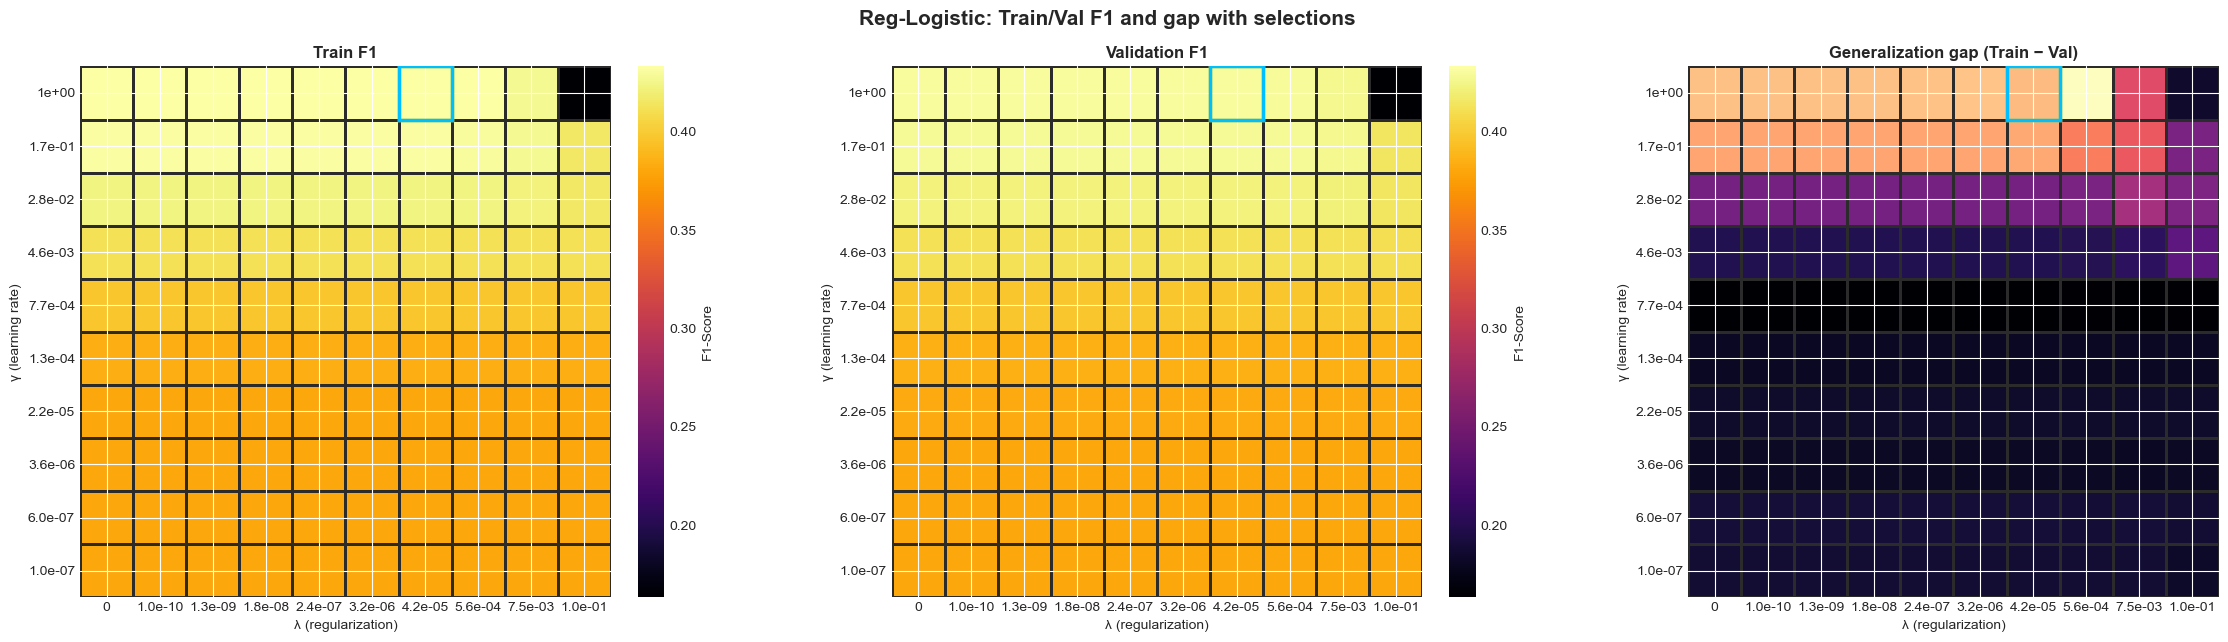

[BEST raw] gamma=1  lambda=4.22e-05  F1_val=0.4303  gap=0.0027
[PRE-OVERFIT] gamma=1  lambda=4.22e-05  F1_val=0.4303  gap=0.0027  (gap_max=0.01)


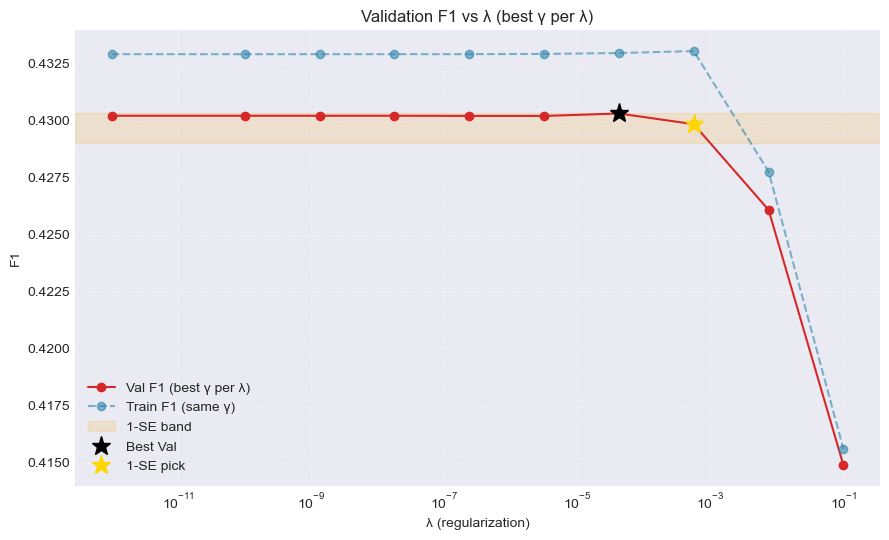

[1-SE] lambda=0.000562  gamma=1  F1_val=0.4299  gap=0.0032  (SE=0.0013)


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

# Generalization gap matrix and pre-overfit selection
gap = train_mean - val_mean
gap_max = 0.010  # overfitting tolerance (adjust e.g. 0.005–0.02)

# Index of best validation F1 (unconstrained)
best_i, best_j = np.unravel_index(np.nanargmax(val_mean), val_mean.shape)

# Best under gap constraint
mask = gap <= gap_max
if np.any(mask):
    flat = np.where(mask, val_mean, -np.inf)
    pre_i, pre_j = np.unravel_index(np.argmax(flat), val_mean.shape)
else:
    # Fallback multi-objective (val - alpha*gap)
    alpha = 0.5
    score = val_mean - alpha * np.clip(gap, 0, None)
    pre_i, pre_j = np.unravel_index(np.argmax(score), score.shape)

def _fmt_vals(vals):
    out = []
    for v in vals:
        if v == 0:
            out.append("0")
        elif v >= 1:
            out.append(f"{v:.0e}")
        else:
            out.append(f"{v:.1e}")
    return out

# Heatmaps + selections
G, L = len(gammas), len(lambdas)
x_edges = np.arange(L + 1) - 0.5
y_edges = np.arange(G + 1) - 0.5

fig, axes = plt.subplots(1, 3, figsize=(24, 6.5))
cmap = plt.get_cmap('inferno')
vmin, vmax = float(min(train_mean.min(), val_mean.min())), float(max(train_mean.max(), val_mean.max()))
norm = Normalize(vmin=vmin, vmax=vmax)

for ax, m, title in zip(axes[:2], [train_mean, val_mean], ["Train F1", "Validation F1"]):
    pc = ax.pcolormesh(
        x_edges, y_edges, m, cmap=cmap, norm=norm, shading='flat',
        edgecolors='#2b2b2b', linewidth=0.8, antialiased=False, zorder=0
)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(L)); ax.set_yticks(np.arange(G))
    ax.set_xticklabels(_fmt_vals(lambdas)); ax.set_yticklabels(_fmt_vals(gammas))
    ax.set_xlabel('λ (regularization)'); ax.set_ylabel('γ (learning rate)')
    ax.set_title(title, fontweight='bold')
    for (ii, jj, color, lw) in [(best_i, best_j, 'gold', 2.5), (pre_i, pre_j, 'deepskyblue', 2.5)]:
        ax.add_patch(Rectangle((jj-0.5, ii-0.5), 1, 1, fill=False, ec=color, lw=lw, zorder=3))
    cbar = plt.colorbar(pc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('F1-Score')

# Gap heatmap
gap_cmap = plt.get_cmap('magma')
gc = axes[2].pcolormesh(
    x_edges, y_edges, gap, cmap=gap_cmap, shading='flat',
    edgecolors='#2b2b2b', linewidth=0.8, antialiased=False, zorder=0
)
axes[2].set_aspect('equal')
axes[2].set_xticks(np.arange(L)); axes[2].set_yticks(np.arange(G))
axes[2].set_xticklabels(_fmt_vals(lambdas)); axes[2].set_yticklabels(_fmt_vals(gammas))
axes[2].set_xlabel('λ (regularization)'); axes[2].set_ylabel('γ (learning rate)')
axes[2].set_title('Generalization gap (Train − Val)', fontweight='bold')
try:
    axes[2].contour(np.arange(L), np.arange(G), gap, levels=[gap_max], colors='cyan', linewidths=2)
except Exception:
    pass
for (ii, jj, color, lw) in [(best_i, best_j, 'gold', 2.5), (pre_i, pre_j, 'deepskyblue', 2.5)]:
    axes[2].add_patch(Rectangle((jj-0.5, ii-0.5), 1, 1, fill=False, ec=color, lw=lw, zorder=3))

fig.suptitle('Reg-Logistic: Train/Val F1 and gap with selections', fontsize=15, fontweight='bold')
fig.tight_layout()
os.makedirs(config.PICT_DIR, exist_ok=True)
plt.savefig(os.path.join(config.PICT_DIR, 'reglog_heatmap_with_gap.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[BEST raw] gamma={gammas[best_i]:.3g}  lambda={lambdas[best_j]:.3g}  F1_val={val_mean[best_i,best_j]:.4f}  gap={gap[best_i,best_j]:.4f}")
print(f"[PRE-OVERFIT] gamma={gammas[pre_i]:.3g}  lambda={lambdas[pre_j]:.3g}  F1_val={val_mean[pre_i,pre_j]:.4f}  gap={gap[pre_i,pre_j]:.4f}  (gap_max={gap_max})")

# λ curve with 1-SE rule: best γ per λ, then pick "simpler" within one standard error
K = len(FOLDS) if 'FOLDS' in globals() else 5
best_gamma_per_lambda = np.argmax(val_mean, axis=0)
val_best_per_lambda = val_mean[best_gamma_per_lambda, np.arange(L)]
train_at_best = train_mean[best_gamma_per_lambda, np.arange(L)]
std_best_per_lambda = val_std[best_gamma_per_lambda, np.arange(L)]
gap_vec = train_at_best - val_best_per_lambda

best_lambda_idx = int(np.argmax(val_best_per_lambda))
best_val = float(val_best_per_lambda[best_lambda_idx])
se = float(std_best_per_lambda[best_lambda_idx] / max(1, np.sqrt(K)))  # standard error

within = np.where(val_best_per_lambda >= best_val - se)[0]
lambda_1se_idx = int(within[-1]) if len(within) else best_lambda_idx
gamma_1se_idx = int(best_gamma_per_lambda[lambda_1se_idx])

x_plot = np.array([l if l > 0 else 1e-12 for l in lambdas], dtype=float)

plt.figure(figsize=(9, 5.5))
plt.semilogx(x_plot, val_best_per_lambda, 'o-', color='#D62828', label='Val F1 (best γ per λ)')
plt.semilogx(x_plot, train_at_best, 'o--', color='#2E86AB', alpha=0.6, label='Train F1 (same γ)')
plt.axhspan(best_val - se, best_val, color='orange', alpha=0.15, label='1-SE band')
plt.plot(x_plot[best_lambda_idx], val_best_per_lambda[best_lambda_idx], 'k*', ms=14, label='Best Val')
plt.plot(x_plot[lambda_1se_idx], val_best_per_lambda[lambda_1se_idx], '*', ms=14, color='gold', label='1-SE pick')
plt.xlabel('λ (regularization)'); plt.ylabel('F1'); plt.title('Validation F1 vs λ (best γ per λ)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(config.PICT_DIR, 'lambda_curve_1SE.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[1-SE] lambda={lambdas[lambda_1se_idx]:.3g}  gamma={gammas[gamma_1se_idx]:.3g}  F1_val={val_best_per_lambda[lambda_1se_idx]:.4f}  gap={gap_vec[lambda_1se_idx]:.4f}  (SE={se:.4f})")

In [10]:
# Compute or load hyperparameter curves 
import os
import numpy as np
import importlib
import implementation_test_plot as itp
itp = importlib.reload(itp)
import implementations, metrics, config

curves_path = os.path.join("..", "data_saving", "curves_results_min.npz")

# Multiprocessing: keep some cores free
from os import cpu_count
nproc = max(1, (cpu_count() or 2) - 3)

curves, summary = None, None
if os.path.exists(curves_path):
    try:
        curves, summary = itp.load_curves(curves_path)
        print(f"[Cache] Loaded curves from {curves_path}")
    except Exception as e:
        print(f"[Cache] Failed to load curves ({e}); recomputing…")

if curves is None:
    y_tr_pm1 = metrics.to_pm1_labels(y_tr_01)
    curves, summary = itp.compute_hyperparam_curves(
        X_tr, y_tr_pm1, y_tr_01, FOLDS,
        n_trials=20, seed=config.RNG_SEED, max_iters=config.TUNING_MAX_ITERS,
        use_multiprocessing=True, processes=nproc,
)
    itp.save_curves(curves_path, curves, summary)

# Least Squares F1 (approx via near-zero Ridge) for the 6th bar
try:
    y_tr_pm1 = metrics.to_pm1_labels(y_tr_01)
    ls_f1_scores = []
    for tr, va in FOLDS:
        w_ls, _ = implementations.ridge_regression(y_tr_pm1[tr], X_tr[tr], lambda_=1e-10)
        y_pred_pm1 = np.sign(X_tr[va] @ w_ls)
        y_pred_pm1[y_pred_pm1 == 0] = 1  # tie-break
        y_pred_01 = metrics.to_01_labels(y_pred_pm1)
        ls_f1_scores.append(metrics.precision_recall_f1(y_tr_01[va], y_pred_01)[2])
    summary["best_f1_ls"] = float(np.mean(ls_f1_scores))
    print(f"[LS] F1 (mean over folds): {summary['best_f1_ls']:.4f}")
except Exception as e:
    print(f"[Info] Least Squares F1 skipped: {e}")

[Cache] Loaded curves from ..\data_saving\curves_results_min.npz
[LS] F1 (mean over folds): 0.1029
[LS] F1 (mean over folds): 0.1029


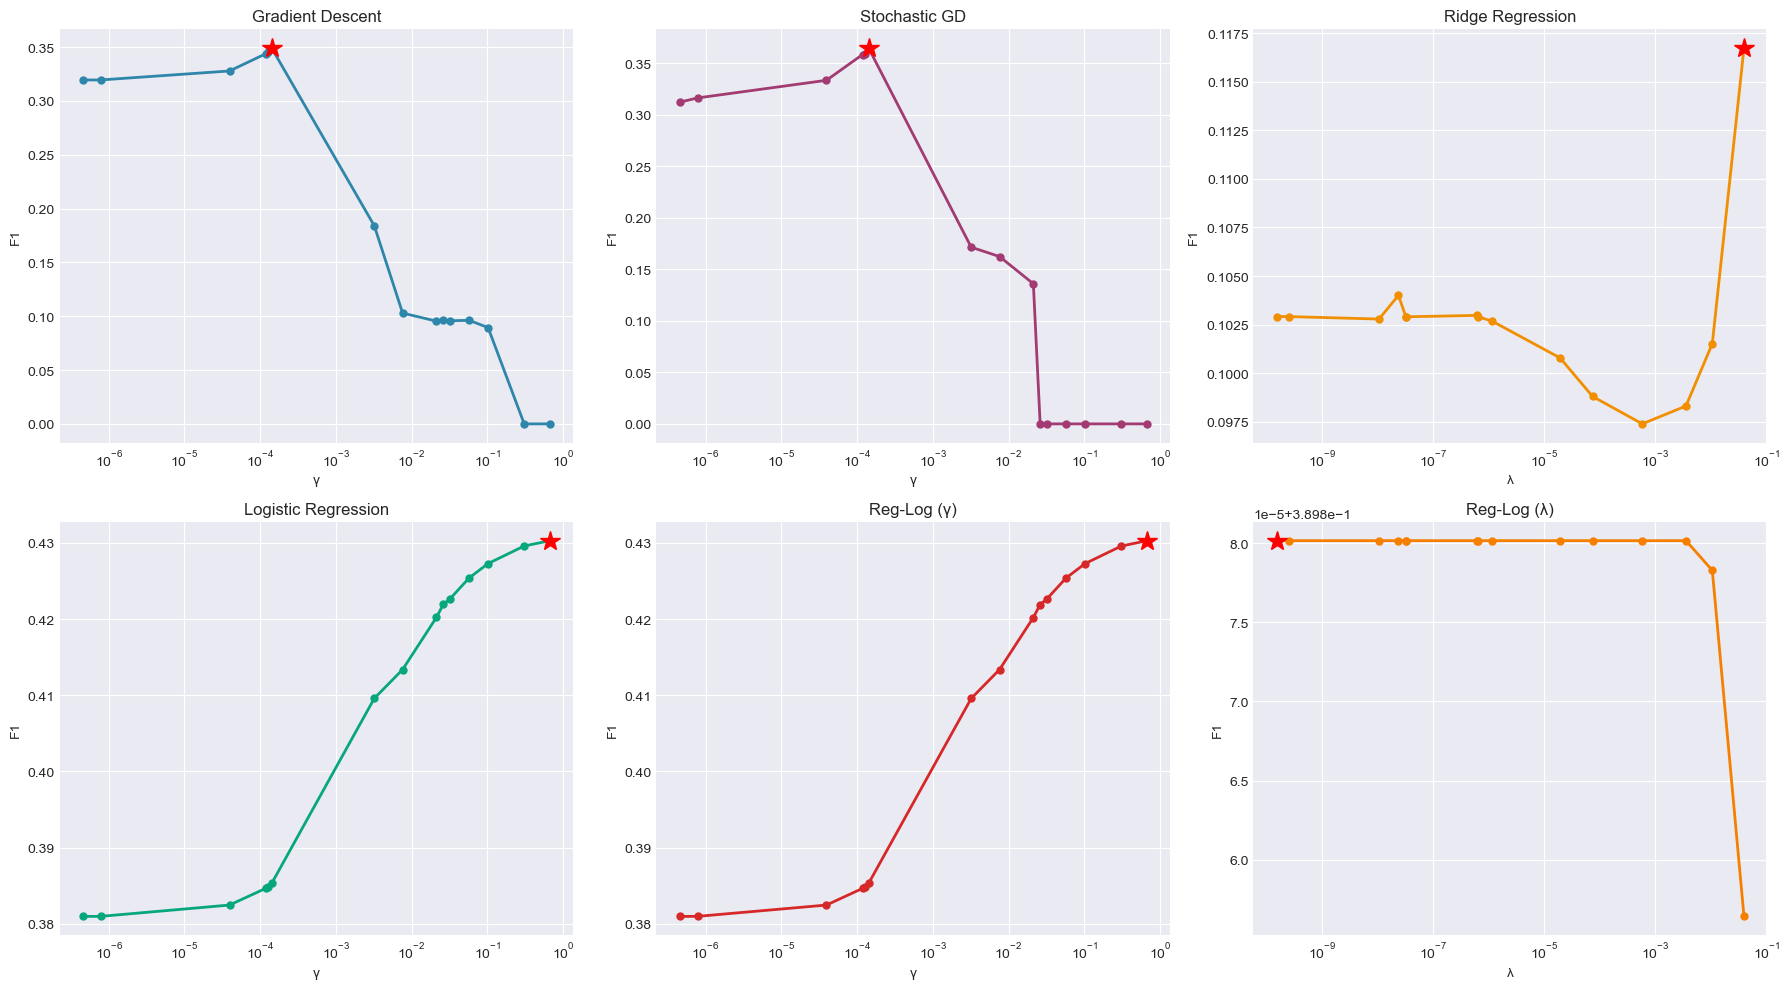

C:\Users\alexb\AppData\Local\Temp\ipykernel_6028\3169888402.py:90: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\alexb\AppData\Local\Temp\ipykernel_6028\3169888402.py:91: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(os.path.join(config.PICT_DIR, 'final_comparison_min.png'), dpi=300, bbox_inches='tight')
C:\Users\alexb\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\alexb\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


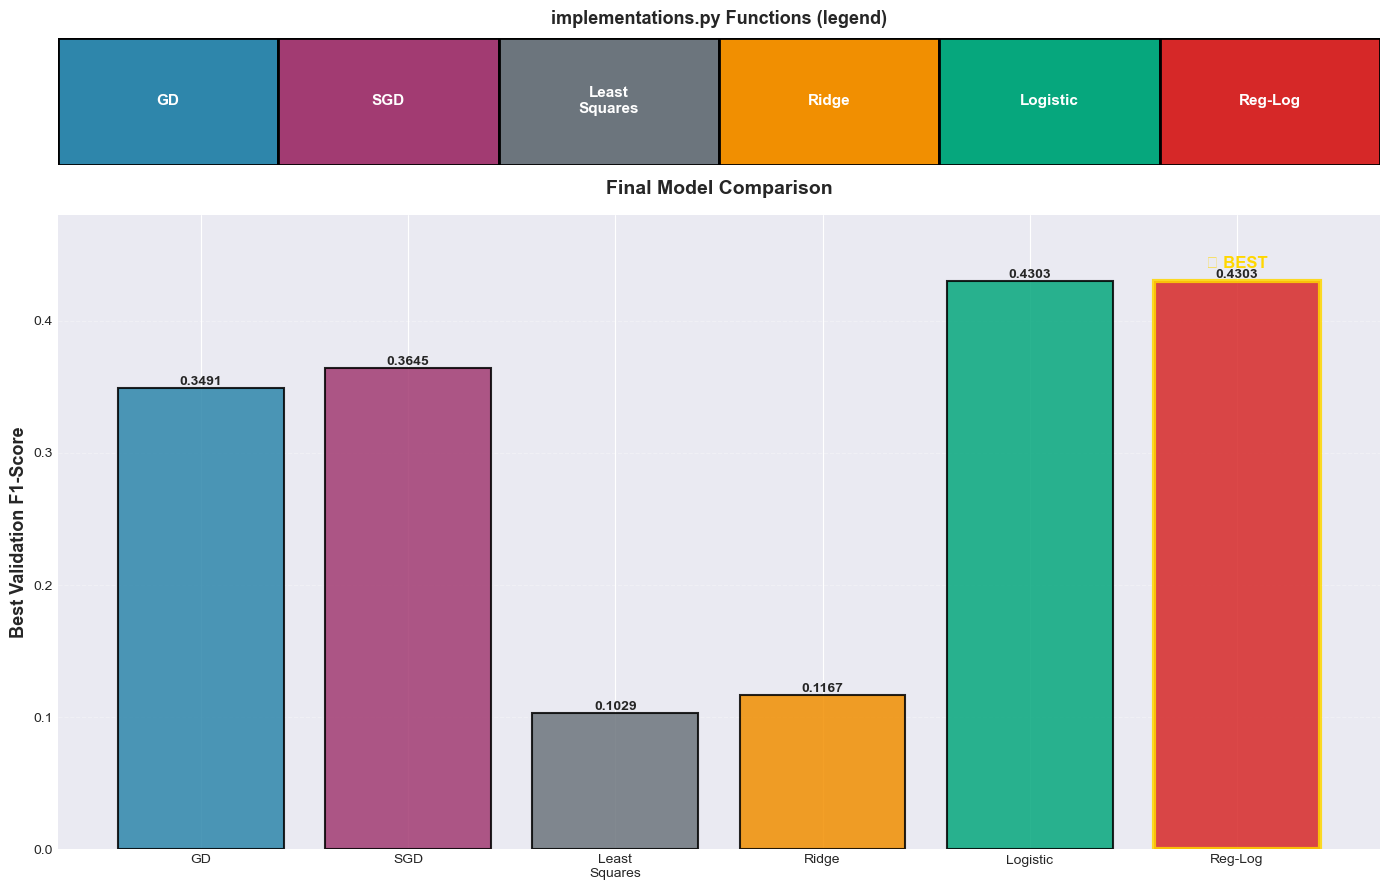

In [11]:
# Plot γ/λ curves + 6-function color bar comparison
import os
import importlib
import config
config = importlib.reload(config)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# GD vs γ
best_idx = int(np.argmax(curves["gd_f1"]))
axes[0].semilogx(curves["gammas"], curves["gd_f1"], 'o-', linewidth=2, markersize=5, color='#2E86AB')
axes[0].plot(curves["gammas"][best_idx], curves["gd_f1"][best_idx], 'r*', ms=15)
axes[0].set_xlabel('γ'); axes[0].set_ylabel('F1'); axes[0].set_title('Gradient Descent')

# SGD vs γ
best_idx = int(np.argmax(curves["sgd_f1"]))
axes[1].semilogx(curves["gammas"], curves["sgd_f1"], 'o-', linewidth=2, markersize=5, color='#A23B72')
axes[1].plot(curves["gammas"][best_idx], curves["sgd_f1"][best_idx], 'r*', ms=15)
axes[1].set_xlabel('γ'); axes[1].set_ylabel('F1'); axes[1].set_title('Stochastic GD')

# Ridge vs λ
best_idx = int(np.argmax(curves["ridge_f1"]))
axes[2].semilogx(curves["lambdas"], curves["ridge_f1"], 'o-', linewidth=2, markersize=5, color='#F18F01')
axes[2].plot(curves["lambdas"][best_idx], curves["ridge_f1"][best_idx], 'r*', ms=15)
axes[2].set_xlabel('λ'); axes[2].set_ylabel('F1'); axes[2].set_title('Ridge Regression')

# Logistic vs γ
best_idx = int(np.argmax(curves["logreg_f1_vs_gamma"]))
axes[3].semilogx(curves["gammas"], curves["logreg_f1_vs_gamma"], 'o-', linewidth=2, markersize=5, color='#06A77D')
axes[3].plot(curves["gammas"][best_idx], curves["logreg_f1_vs_gamma"][best_idx], 'r*', ms=15)
axes[3].set_xlabel('γ'); axes[3].set_ylabel('F1'); axes[3].set_title('Logistic Regression')

# Reg-Log vs γ
best_idx = int(np.argmax(curves["reglog_f1_vs_gamma"]))
axes[4].semilogx(curves["gammas"], curves["reglog_f1_vs_gamma"], 'o-', linewidth=2, markersize=5, color='#D62828')
axes[4].plot(curves["gammas"][best_idx], curves["reglog_f1_vs_gamma"][best_idx], 'r*', ms=15)
axes[4].set_xlabel('γ'); axes[4].set_ylabel('F1'); axes[4].set_title('Reg-Log (γ)')

# Reg-Log vs λ
best_idx = int(np.argmax(curves["reglog_f1_vs_lambda"]))
axes[5].semilogx(curves["lambdas"], curves["reglog_f1_vs_lambda"], 'o-', linewidth=2, markersize=5, color='#F77F00')
axes[5].plot(curves["lambdas"][best_idx], curves["reglog_f1_vs_lambda"][best_idx], 'r*', ms=15)
axes[5].set_xlabel('λ'); axes[5].set_ylabel('F1'); axes[5].set_title('Reg-Log (λ)')

plt.tight_layout()
os.makedirs(config.PICT_DIR, exist_ok=True)
plt.savefig(os.path.join(config.PICT_DIR, 'hyperparam_curves_min.png'), dpi=300, bbox_inches='tight')
plt.show()

# Final bar comparison with color legend row
fig, (ax_ref, ax_main) = plt.subplots(2, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [1, 5]})
labels = ["GD", "SGD", "Least\nSquares", "Ridge", "Logistic", "Reg-Log"]
colors = ['#2E86AB', '#A23B72', '#6C757D', '#F18F01', '#06A77D', '#D62828']

bar_width = 1.0 / len(labels)
for i, (name, color) in enumerate(zip(labels, colors)):
    rect = Rectangle((i * bar_width, 0), bar_width, 1, facecolor=color, edgecolor='black', linewidth=2)
    ax_ref.add_patch(rect)
    ax_ref.text(i * bar_width + bar_width/2, 0.5, name, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax_ref.set_xlim(0, 1); ax_ref.set_ylim(0, 1); ax_ref.axis('off')
ax_ref.set_title('implementations.py Functions (legend)', fontsize=13, fontweight='bold', pad=10)

scores = [
    summary.get("best_f1_gd", 0.0),
    summary.get("best_f1_sgd", 0.0),
    summary.get("best_f1_ls", 0.0),
    summary.get("best_f1_ridge", 0.0),
    summary.get("best_f1_log_plain", 0.0),
    max(summary.get("best_f1_reglog_gamma", 0.0), summary.get("best_f1_reglog_lambda", 0.0)),
]

bars = ax_main.bar(labels, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
for bar, score in zip(bars, scores):
    ax_main.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

best_idx = int(np.argmax(scores))
bars[best_idx].set_edgecolor('gold'); bars[best_idx].set_linewidth(3)
ax_main.text(best_idx, scores[best_idx] + 0.01, '★ BEST', ha='center', fontsize=12, fontweight='bold', color='gold')

ax_main.set_ylabel('Best Validation F1-Score', fontsize=13, fontweight='bold')
ax_main.set_title('Final Model Comparison', fontsize=14, fontweight='bold', pad=15)
ax_main.set_ylim([0, max(scores) + 0.05])
ax_main.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(config.PICT_DIR, 'final_comparison_min.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot iteration-wise train/validation loss and F1 curves to inspect overfitting
import os, numpy as np, matplotlib.pyplot as plt
import importlib, implementation_test_plot as itp
itp = importlib.reload(itp)

# Choose a point (γ, λ) to analyze – use best or pre-overfit pick from previous cell
gamma_to_use = float(gammas[pre_i]) if 'pre_i' in globals() else float(gammas[np.argmax(val_mean.mean(axis=1))])
lambda_to_use = float(lambdas[pre_j]) if 'pre_j' in globals() else float(lambdas[np.argmax(val_mean.mean(axis=0))])
T = min(400, int(config.TUNING_MAX_ITERS))  # iterations to plot

print(f"[Curves] Using gamma={gamma_to_use:.3g}, lambda={lambda_to_use:.3g}, max_iters={T}")

curves = itp.compute_reglog_loss_curves(X_tr, y_tr_01, FOLDS, gamma_to_use, lambda_to_use, max_iters=T)
iters = curves['iters']

# Loss subplot
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
tr_m, tr_s = curves['train_mean'], curves['train_std']
va_m, va_s = curves['val_mean'], curves['val_std']
ax1.plot(iters, tr_m, label='Train loss', color='#2E86AB')
ax1.fill_between(iters, tr_m - tr_s, tr_m + tr_s, alpha=0.15, color='#2E86AB')
ax1.plot(iters, va_m, label='Val loss', color='#D62828')
ax1.fill_between(iters, va_m - va_s, va_m + va_s, alpha=0.15, color='#D62828')
best_iter_loss = int(np.argmin(va_m))
ax1.axvline(best_iter_loss, color='gray', ls='--', alpha=0.6)
ax1.set_xlabel('Iteration'); ax1.set_ylabel('Unpenalized logistic loss')
ax1.set_title('Loss vs iteration'); ax1.grid(True, ls='--', alpha=0.3); ax1.legend()

# F1 subplot
ax2 = plt.subplot(1,2,2)
tr_f1_m, tr_f1_s = curves['train_f1_mean'], curves['train_f1_std']
va_f1_m, va_f1_s = curves['val_f1_mean'], curves['val_f1_std']
ax2.plot(iters, tr_f1_m, label='Train F1', color='#2E86AB')
ax2.fill_between(iters, tr_f1_m - tr_f1_s, tr_f1_m + tr_f1_s, alpha=0.15, color='#2E86AB')
ax2.plot(iters, va_f1_m, label='Val F1', color='#D62828')
ax2.fill_between(iters, va_f1_m - va_f1_s, va_f1_m + va_f1_s, alpha=0.15, color='#D62828')
best_iter_f1 = int(np.argmax(va_f1_m))
ax2.axvline(best_iter_f1, color='gold', ls='--', alpha=0.8)
ax2.set_xlabel('Iteration'); ax2.set_ylabel('F1')
ax2.set_title('F1 vs iteration'); ax2.grid(True, ls='--', alpha=0.3); ax2.legend()

plt.tight_layout()
os.makedirs(config.PICT_DIR, exist_ok=True)
plt.savefig(os.path.join(config.PICT_DIR, 'reglog_learning_curves_w_f1.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[Heuristic] Best Val loss at iter={best_iter_loss} | Best Val F1 at iter={best_iter_f1}")

[Curves] Using gamma=1, lambda=4.22e-05, max_iters=400
